In [1]:
import h5py
import os
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
import matplotlib.patches as patches
sns.set_style('darkgrid')
import pickle
from sklearn.utils import shuffle
from matplotlib import gridspec
from matplotlib.lines import Line2D

# Machine learning
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
sns.set_context("poster", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20}) 
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
os.chdir('/Users/trongnguyen/Dropbox/FattyLiver/src/hydrogen/')
from outlierDetection import getBSC_Att, envDetection, filter_BSC_based_on_depth, findOutliers, extract_segment_points

In [5]:
from helper_brl import fattyLiver

# <font  color = #d8bf1e> Folch assay results</font> 

In [6]:
dataBase = fattyLiver.load_labels(threshold = 5)

# Bad rabbits

In [7]:
#badRabbits = [729, 749, 750, 730, 751, 748, 753, 756]
badRabbits = [731, 740, 747, 739, 730, 741, 750, 749, 748, 751, 756]
for bad_rabbit in badRabbits:
    dataBase = dataBase[dataBase.Rabbit != bad_rabbit]
#badRabbits = [750, 752]

# Rabbits ID

In [11]:
#all_idx = [732, 730, 758, 746, 739, 752, 755, 743, 736, 737, 751, 748 ,750, 735, 731, 757, 741, 738, 756, 753, 729, 749, 740, 747]

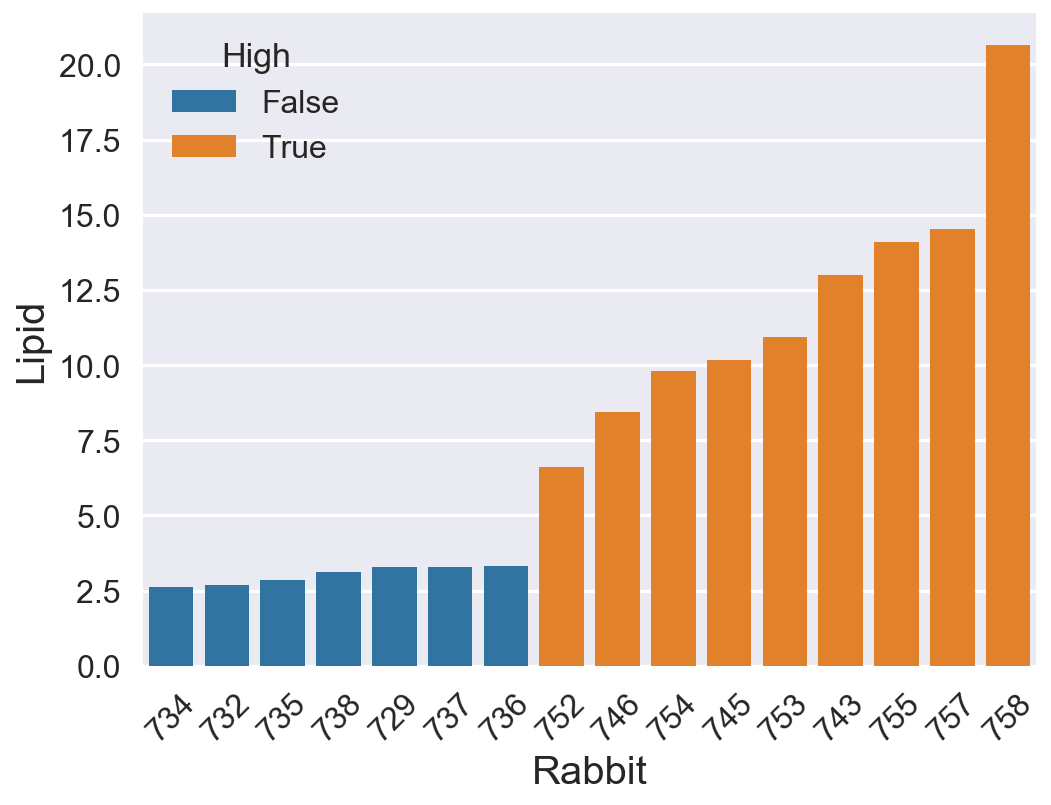

In [8]:
plt.figure(figsize = (8, 6))
g = sns.barplot(x = 'Rabbit', y = 'Lipid', hue = 'High' ,data = dataBase, dodge = False, order =dataBase['Rabbit'])
g1 = plt.xticks(rotation=45)

# <font color=#21d38> Load the data </font>

In [9]:
ATTs_dict, freq_att_dict, freq_bsc_dict, depth_dict, BSCs_dict = {}, {}, {}, {}, {} 
left_dict, right_dict, top_dict, bottom_dict = {}, {}, {}, {} # ROIs of each BSC
att_bottom, bad_BSC = {}, {}

name_tag = 'fix_bug_average_ref_phantom'
for index, row in dataBase.iterrows():
    number = row.Rabbit
    number = str(int(number))
    print(number, end = ', ')
    path = "/Volumes/TrongDrive/Liver_Study/PostProcessedFiles/L" + number + "/L94_left/BSC_ATT/"
    ATTs_dict[number], freq_att_dict[number], BSCs_dict[number], freq_bsc_dict[number], \
    depth_dict[number], left_dict[number], right_dict[number], \
    top_dict[number], bottom_dict[number], att_bottom[number], bad_BSC[number] = getBSC_Att(path,name_tag)

### Assigning training and testing data and labels

In [1]:
%qtconsole

# BSCs using ESD and EAC

In [11]:
from scipy.optimize import least_squares

def gaussian_residuals(coeffs, f, y):
    c = 1540.0 *1e-4 
    A1 = 4 * np.log((np.pi * f)/(np.sqrt(6)*c))
    #A2 = 4 * np.log(f)
    A3 = 6*np.log(coeffs[0] *1e-4) + np.log(coeffs[1])
    A4 = - 0.827 * (np.pi**2/(c**2))* ((coeffs[0]*1e-4)**2) * (f**2)
    return A1 +  A3 + A4 - y

In [12]:
def get_ESD_EAC(freq, bsc):
    x0 = np.array([100, 0.2], dtype=float)
    lq_sol = least_squares(gaussian_residuals, x0, args=(freq, np.log(bsc)), bounds = ([0, 0],np.inf))

    ESD = lq_sol.x[0]
    EAC = 10*np.log10(lq_sol.x[1])
    return (ESD, EAC)

In [13]:
def features_gaussian_ff(X_train, freq):
    #from IPython.core.debugger import Pdb; Pdb().set_trace()
    ESD_EAC = np.zeros((X_train.shape[0], 2))
    for i in range(X_train.shape[0]):
        ESD, EAC = get_ESD_EAC(freq, X_train[i,:])
        ESD_EAC[i, 0] = ESD
        ESD_EAC[i, 1] = EAC
        if (i%100==0):
            print(i, end =',')
    return ESD_EAC

In [14]:
freq = freq_bsc_dict['735']['2']

In [15]:
all_idx = []
for i in range(4):
    no_testing = 2
    testing_idx = fattyLiver.choose_testing_rabbits_indices(dataBase, no_testing, all_idx)
    all_idx.extend(testing_idx)
    print(testing_idx)

[732, 736, 753, 752]
[735, 738, 758, 755]
[729, 737, 757, 746]
[745, 754]


[732, 736, 753, 752]
734,Skip,735,738,729,737,Skip,Skip,746,754,745,Skip,743,755,757,758,Skip, 732,Skip, Skip, Skip, Skip, 736,752,Skip, Skip, Skip, 753,Skip, Skip, Skip, Skip, 0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,0,100,200,300,400,500,600,700,800,900,1000,Training accuracy: 0.946256038647
Testing accuracy: 0.847424684159


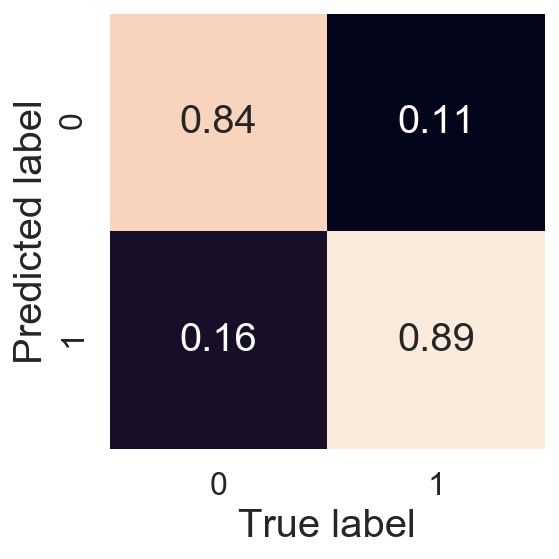

[735, 738, 758, 755]
734,732,Skip,Skip,729,737,736,752,746,754,745,753,743,Skip,757,Skip,Skip, Skip, 735,738,Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, Skip, 755,Skip, 758,0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,0,100,200,300,Training accuracy: 0.940823327616
Testing accuracy: 0.883852691218


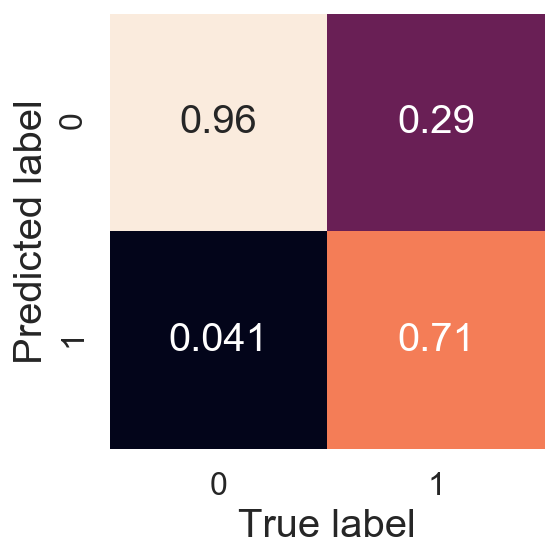

[729, 737, 757, 746]
734,732,735,738,Skip,Skip,736,752,Skip,754,745,753,743,755,Skip,758,Skip, Skip, Skip, Skip, 729,737,Skip, Skip, 746,Skip, Skip, Skip, Skip, Skip, 757,Skip, 0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,0,100,200,300,400,500,600,Training accuracy: 0.955677290837
Testing accuracy: 0.738552437223


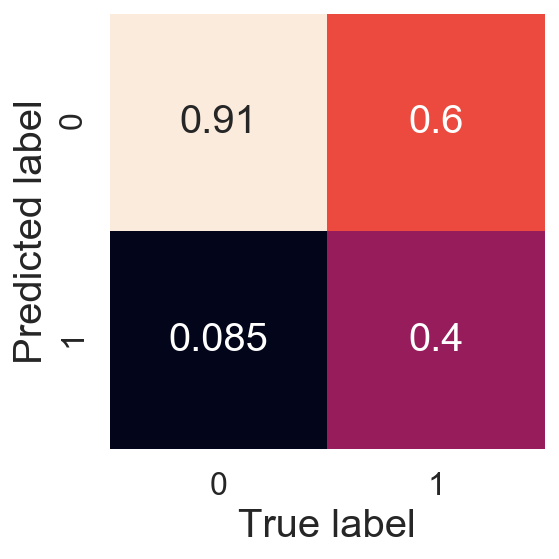

In [28]:
for i in range(3):
    testing_idx = all_idx[i*4:i*4+4]
    print(testing_idx)
    X_train, y_train = fattyLiver.get_training_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict)
    X_test, y_test = fattyLiver.get_testing_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict)

    # Randomize the training data. The testing data was not randomized to get the frame by frame accuracy. 
    #(possible to randomize, but need to keep track of the randomization, seems unneccessary). 
    X_train = X_train.T
    X_test = X_test.T
    
    
    rows, cols = np.where(X_train < 0)
    idx_negative = np.unique(rows)
    if (idx_negative.size > 0): 
        X_train = np.delete(X_train, idx_negative.item(), 0)
        y_train = np.delete(y_train, idx_negative.item())
    
    rows, cols = np.where(X_test < 0)
    idx_negative = np.unique(rows)
    if (idx_negative.size >0):
        X_test = np.delete(X_test, idx_negative.item(), 0)
        y_test = np.delete(y_test, idx_negative.item())
    
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    #X_log_train = np.log(X_train)
    #X_log_test = np.log(X_test)
    #linear_train = linearFit(X_log_train,freq)
    #linear_test = linearFit(X_log_test,freq)
    
    linear_train = features_gaussian_ff(X_train, freq.squeeze())
    linear_test = features_gaussian_ff(X_test, freq.squeeze())
    
    linear_svm = svm.SVC()
    
    clf = svm.SVC(C=1.0, kernel='rbf', gamma=0.1)
    clf.fit(linear_train, y_train)
    
    linear_predict  = clf.predict(linear_test)
    linear_train_predict = clf.predict(linear_train)
    
    print("Training accuracy:", accuracy_score(y_train, linear_train_predict))
    print("Testing accuracy:", accuracy_score(y_test, linear_predict))
    
    linear_cm = confusion_matrix(y_test, linear_predict)
    n_cm_ln = linear_cm.astype('float') / linear_cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(n_cm_ln.T, square=True, annot=True, cbar=False)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()

In [127]:
from sklearn.model_selection import GridSearchCV

In [128]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}


In [130]:
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, verbose=1)

In [131]:
grid_search.fit(linear_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [132]:
grid_search.best_params_

{'C': 1, 'gamma': 0.1}

In [25]:
def round_median(a):
    return np.around(np.median(np.array(a)), decimals = 2)

# Plot BSC

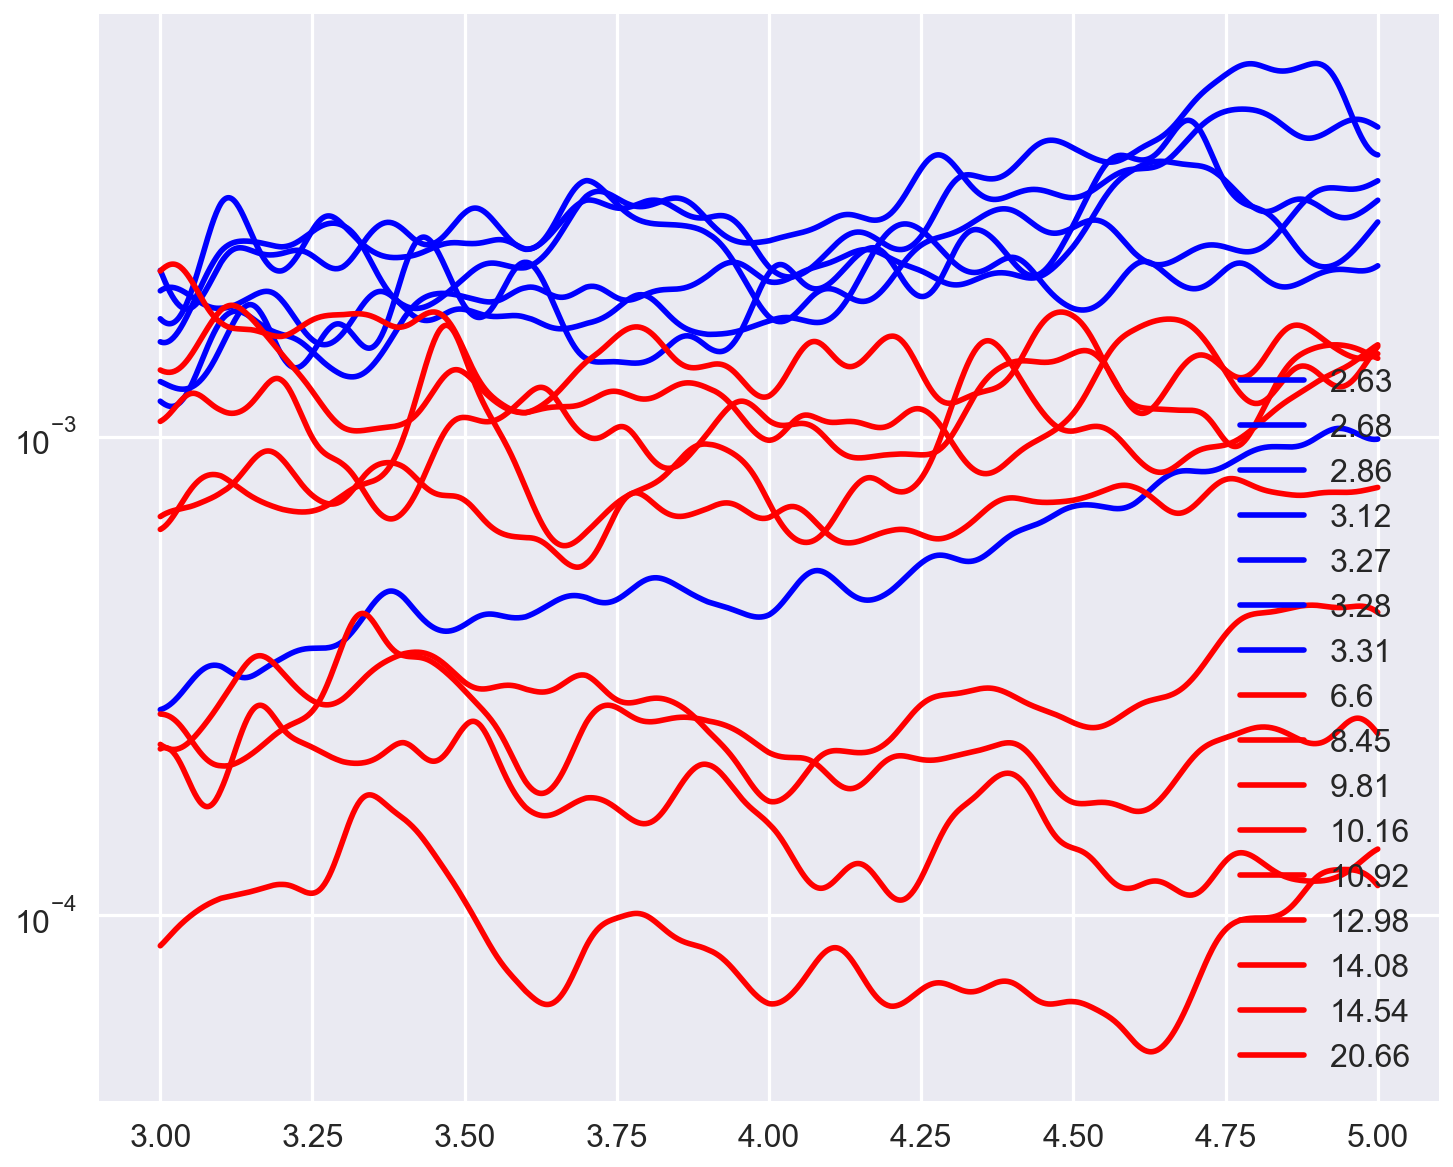

In [26]:
esd_eac_lipid = np.zeros((len(dataBase), 5))
count = 0

plt.figure(figsize = (12, 10))

bsc_low = []
bsc_high = []

for index, row in dataBase.iterrows():
    number = str(row.Rabbit)
    lipid = row.Lipid
    mean_X2 = np.zeros(1024)
    c_m_X2 = 0
    for frame_no in BSCs_dict[number].keys():
        if (BSCs_dict[number][frame_no].shape[1] ==0):
            continue
        X2 = np.mean(BSCs_dict[number][frame_no], axis =1)
        if ((int(frame_no) > 0) and (int(frame_no) < 50)): # 15 and 35 
            mean_X2 = mean_X2 + X2
            c_m_X2 = c_m_X2 + 1
            
    if (c_m_X2>0):
        if (lipid >5):
            plt.semilogy(freq, mean_X2/c_m_X2, label = str(lipid), c = 'r')
            bsc_high.append(mean_X2/c_m_X2)
        else:
            plt.semilogy(freq, mean_X2/c_m_X2, label = str(lipid), c = 'b')
            bsc_low.append(mean_X2/c_m_X2)
    else:
        print(number)
    
plt.legend()    

/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


(0.0001, 0.01)

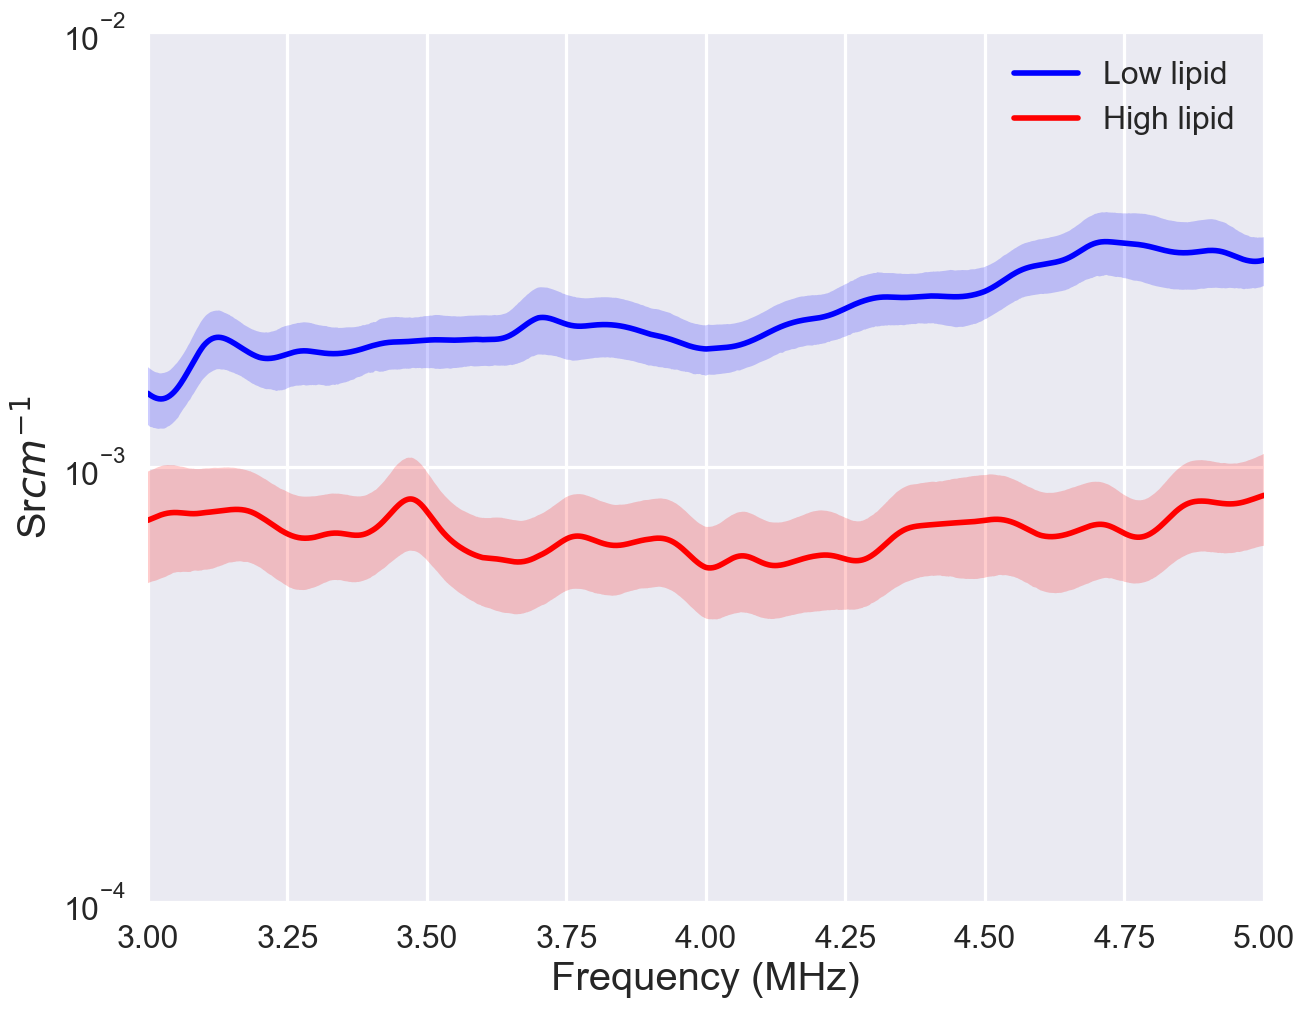

In [21]:
f, ax = plt.subplots(figsize=(10, 8))
ax.set(yscale="log")
sns.tsplot(data = np.vstack(bsc_low), time = freq,  color = 'b', condition = "Low lipid")
sns.tsplot(data =  np.vstack(bsc_high),time = freq,  color = 'r', condition = 'High lipid')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Sr$cm^{-1}$')
ax.set_ylim([10**-4,10**-2])
#ax.set_yticks(10**(np.linspace(-4, -2, 12)))

ESD, EAC of low lipid rabbits 155.899265574 27.1531516274
ESD, EAC of low lipid rabbits 189.048571661 19.8842700174


Text(0,0.5,'Sr$cm^{-1}$')

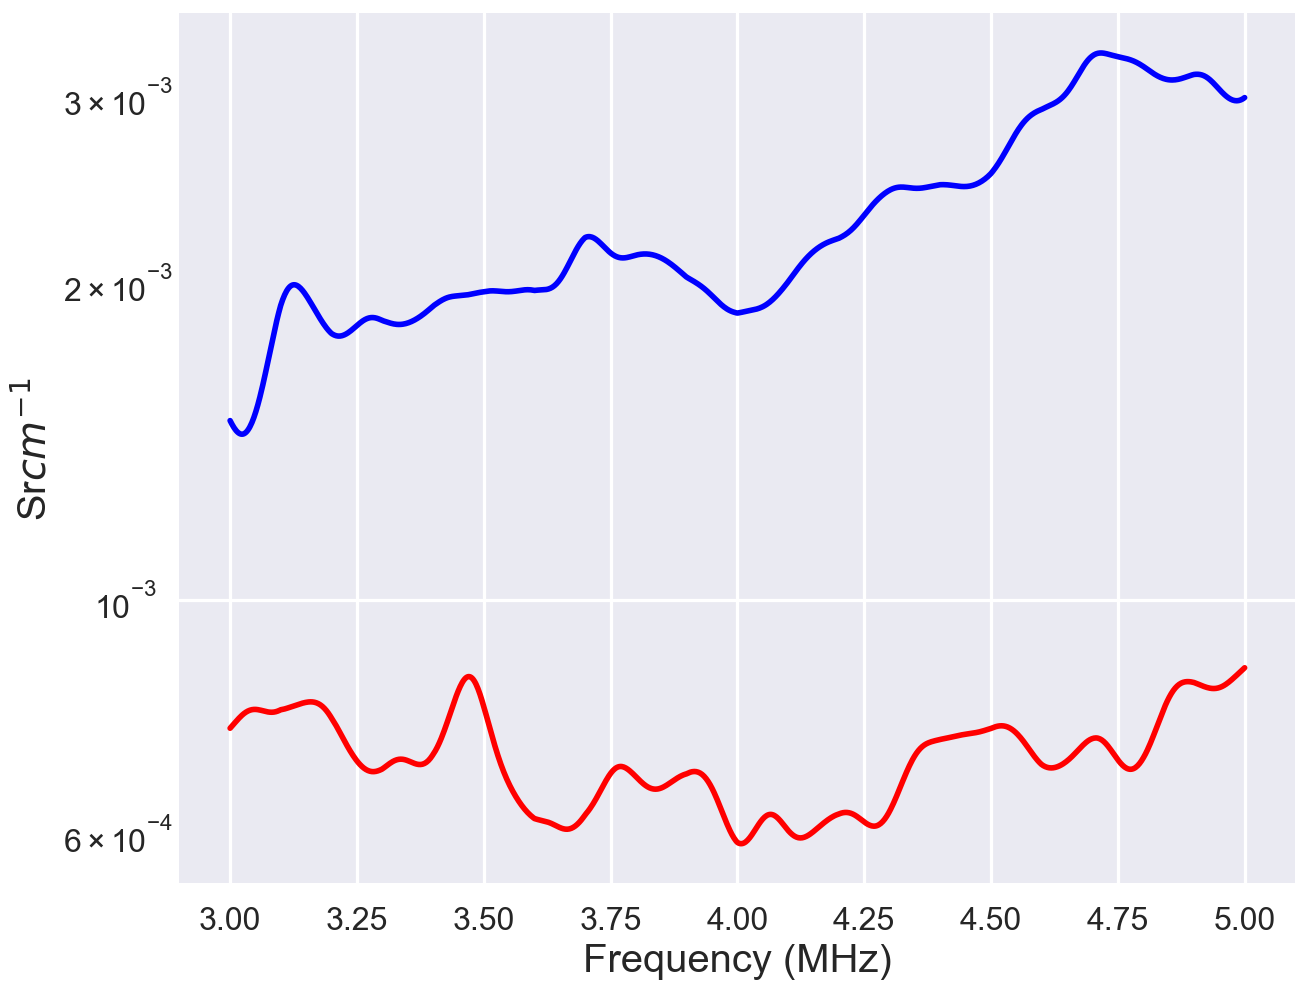

In [23]:
plt.figure(figsize = (10, 8))
avg_BSC_low = np.mean(np.vstack(bsc_low), axis =0)
plt.semilogy(freq, avg_BSC_low, c = 'b', label = 'Low lipid')
esd, eac = get_ESD_EAC(freq.squeeze(), avg_BSC_low)
print("ESD, EAC of low lipid rabbits", esd, eac)

avg_BSC_high = np.mean(np.vstack(bsc_high), axis =0)
plt.semilogy(freq, avg_BSC_high, c = 'r', label = 'High lipid')
esd, eac = get_ESD_EAC(freq.squeeze(), avg_BSC_high)
print('ESD, EAC of low lipid rabbits', esd, eac)                       

plt.xlabel('Frequency (MHz)')
plt.ylabel('Sr$cm^{-1}$')


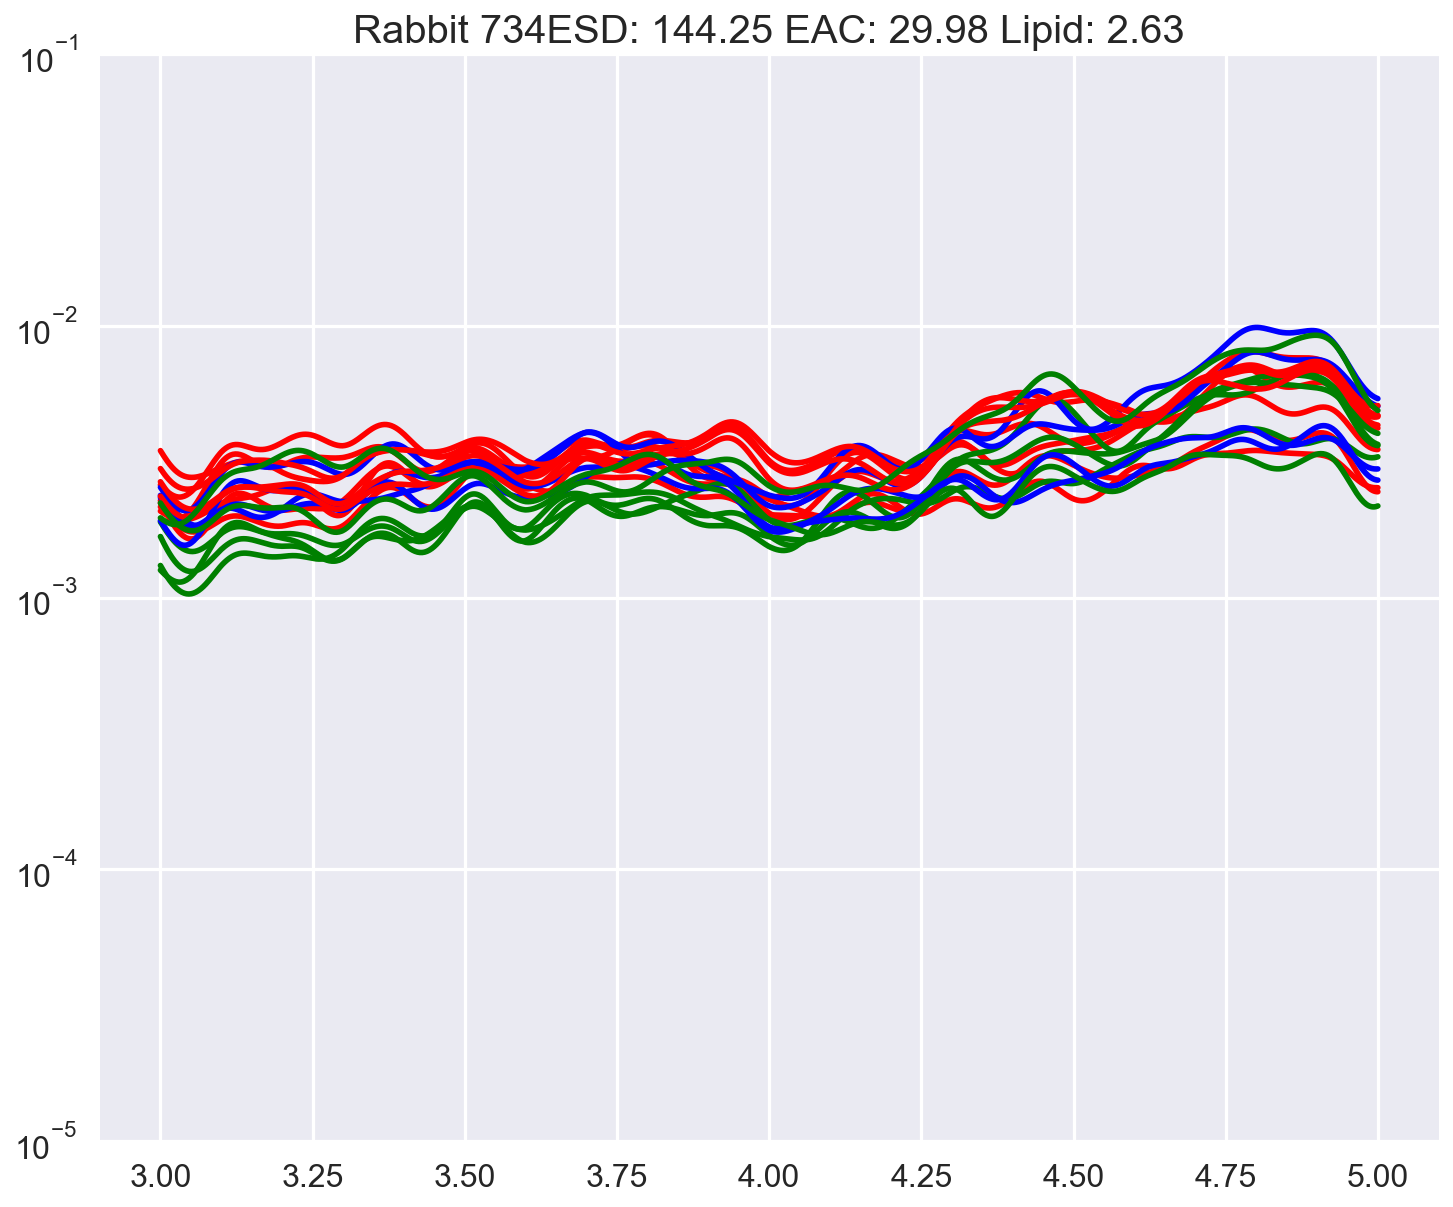

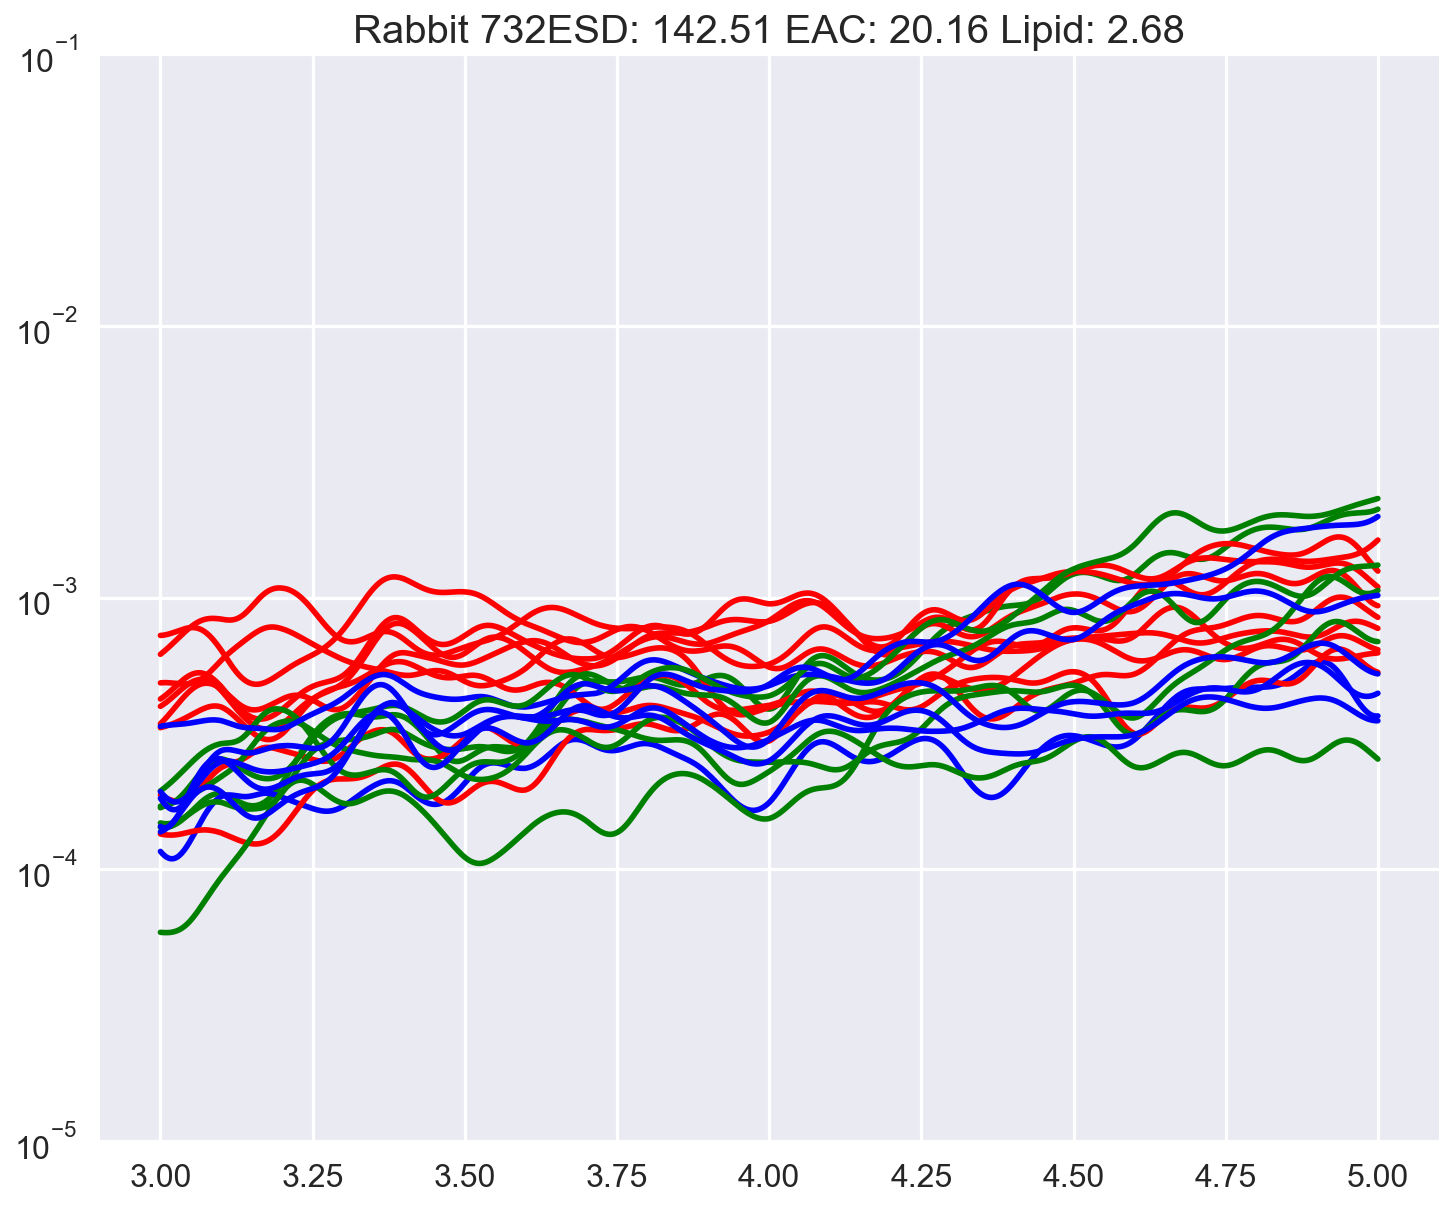

/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


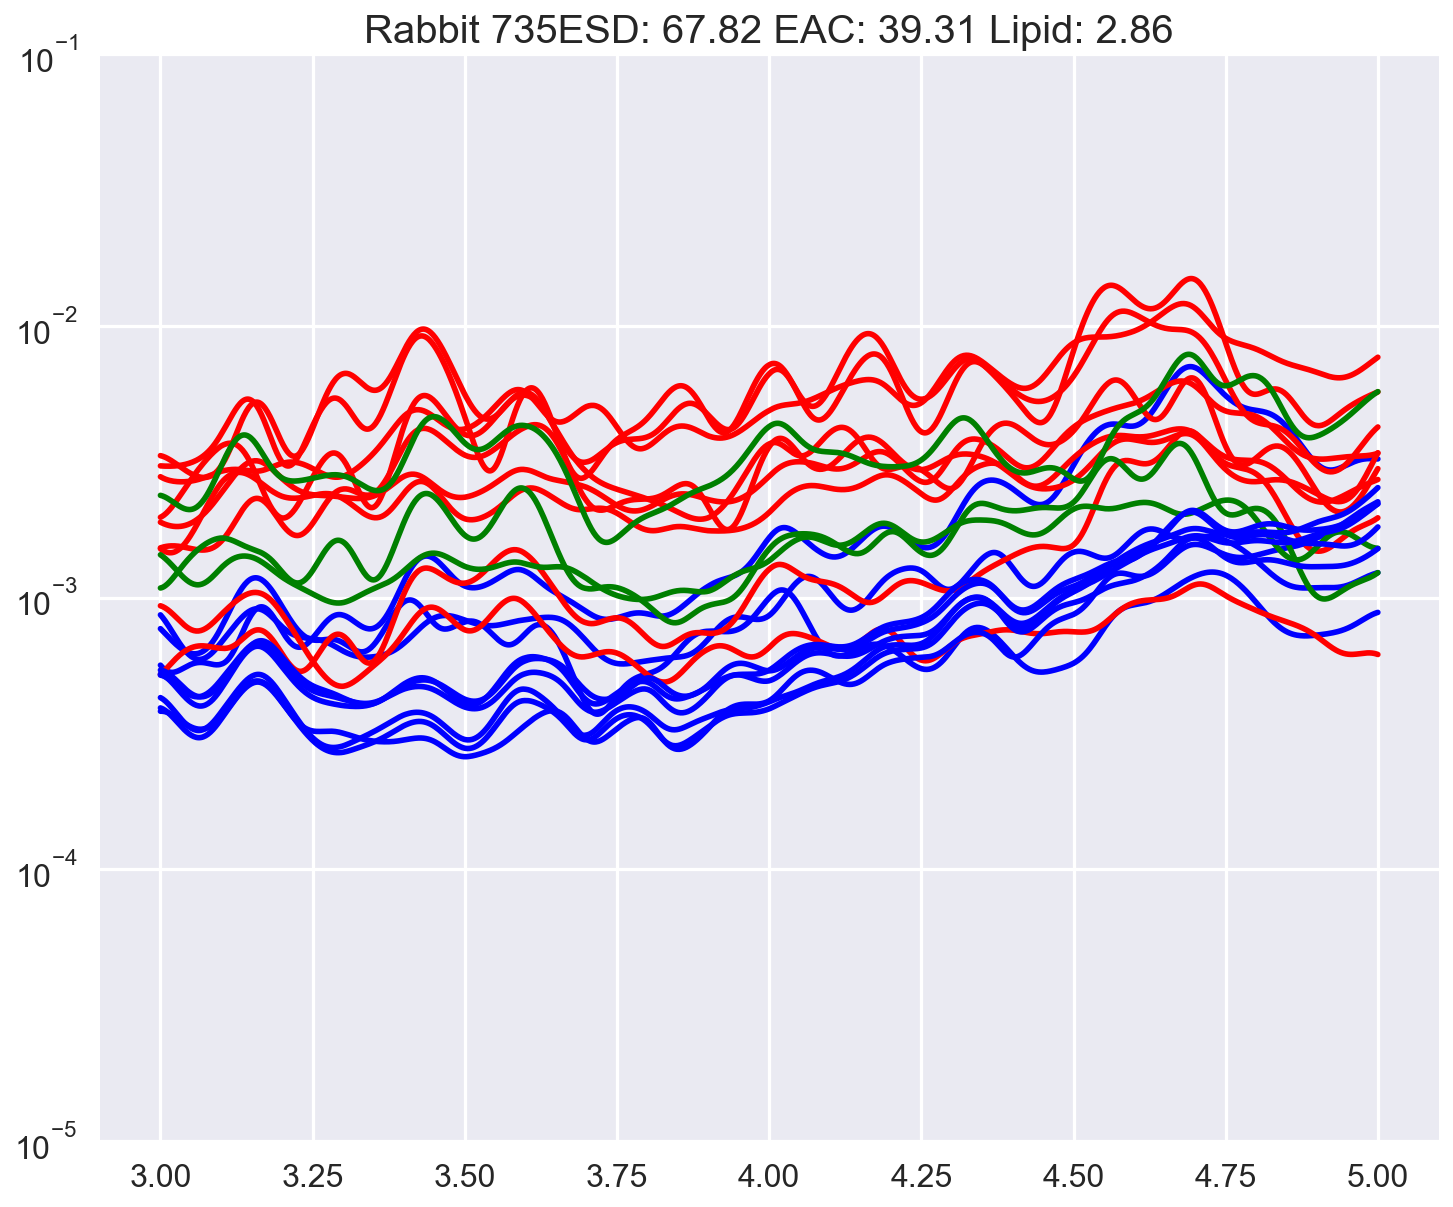

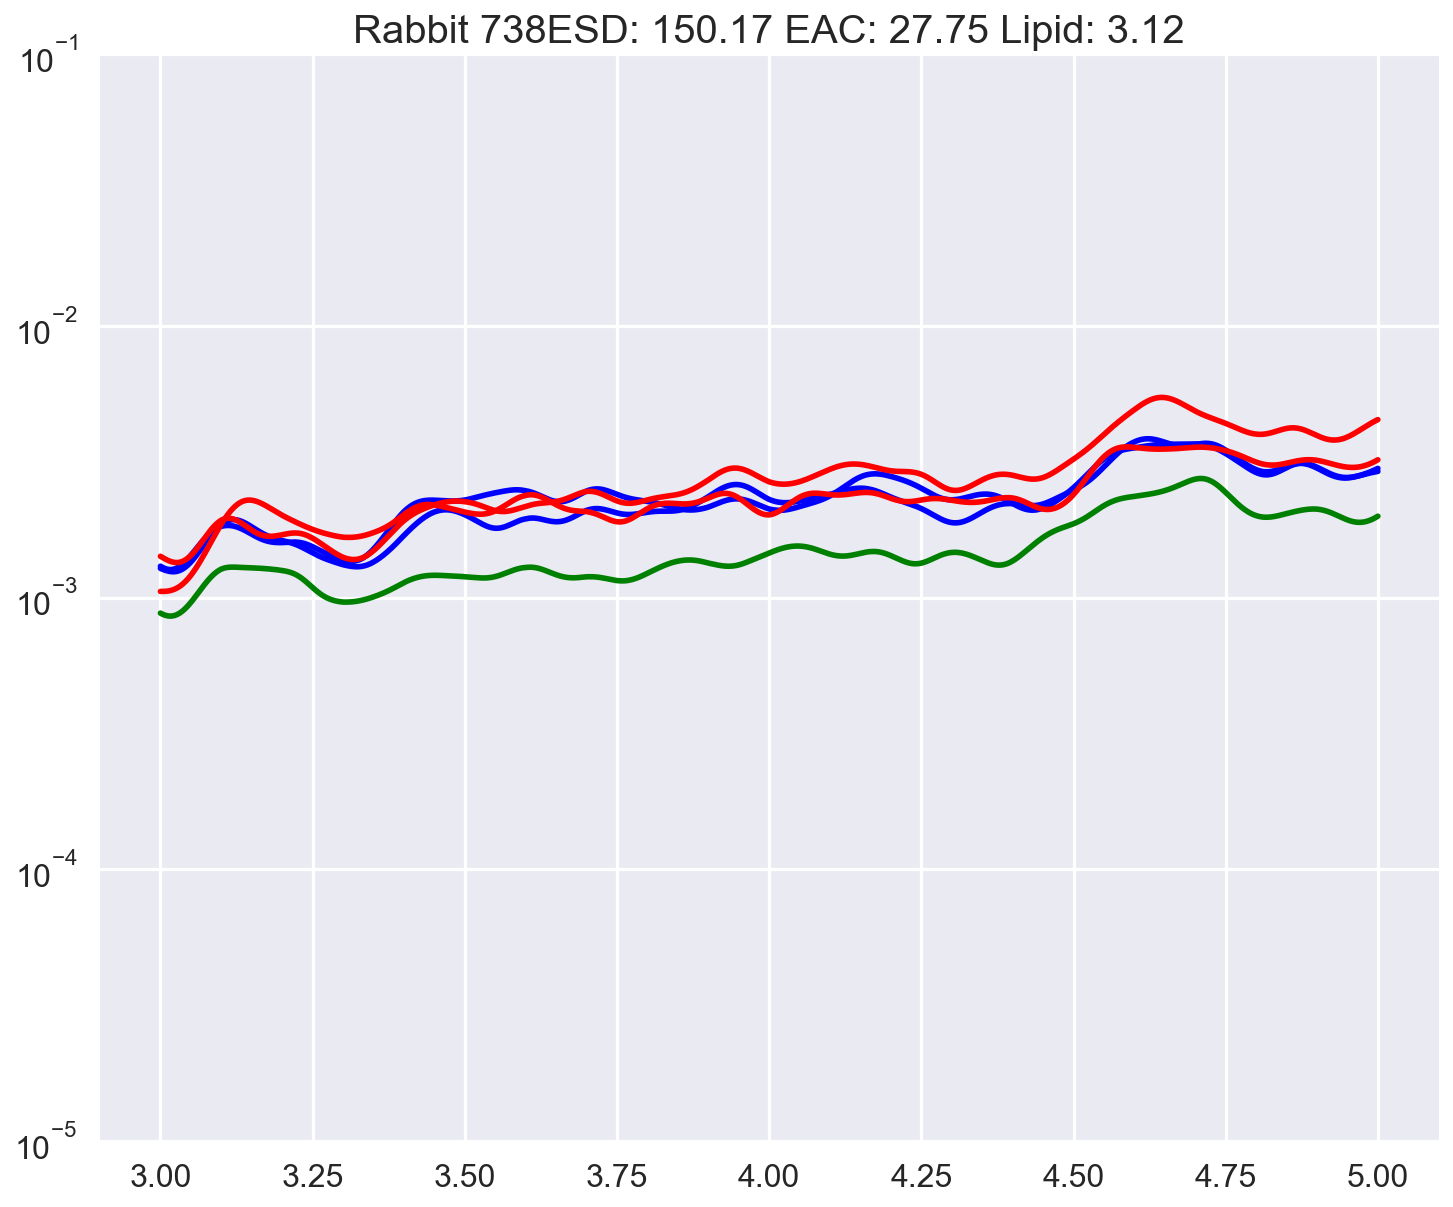

ValueError: Residuals are not finite in the initial point.

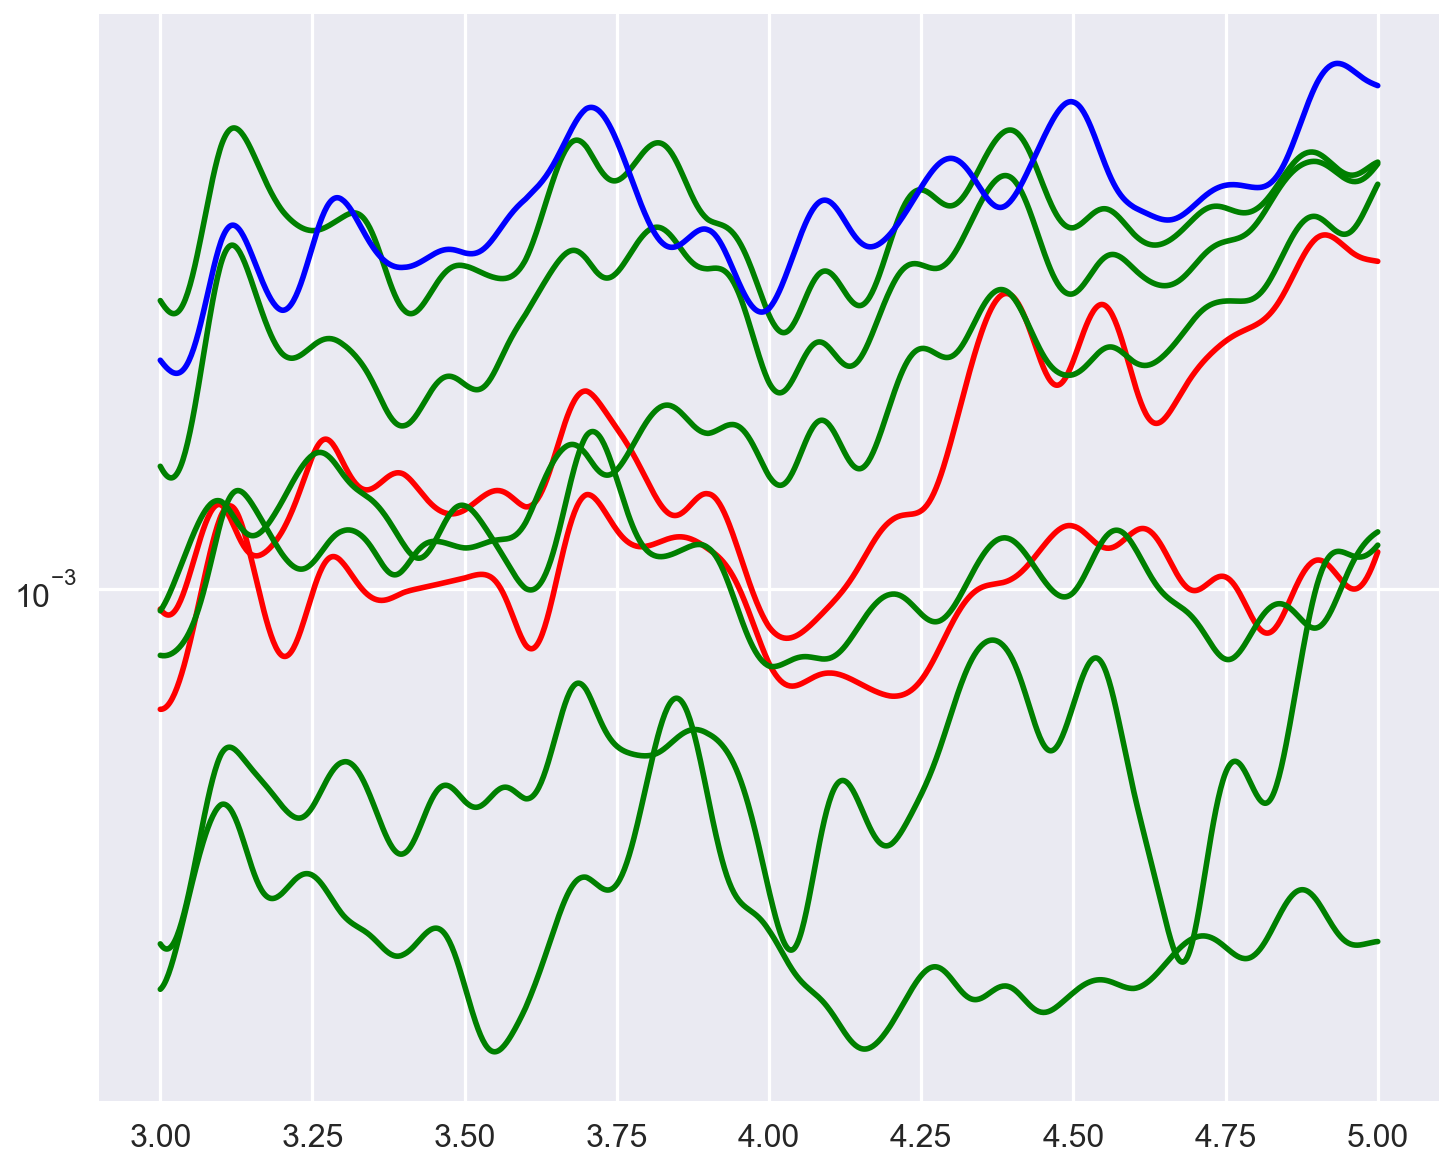

In [27]:
esd_eac_lipid = np.zeros((len(dataBase), 5))
count = 0
for index, row in dataBase.iterrows():
    number = str(row.Rabbit)
    lipid = row.Lipid
    
    ESD = []
    EAC = []
    SLOPE = []
    INTERCEPT =[]
    plt.figure(figsize = (12, 10))
    for frame_no in BSCs_dict[number].keys():
        X2 = np.mean(BSCs_dict[number][frame_no], axis =1)
        if ((int(frame_no) > 35)):
            plt.semilogy(freq.squeeze(), X2, c = 'red')
        elif ((int(frame_no)>15)):
            plt.semilogy(freq.squeeze(), X2, c = 'blue')
            esd, eac = get_ESD_EAC(freq.squeeze(), X2)
            slope, intercept = np.polyfit(freq.squeeze(), np.log(X2), 1)
            ESD.append(esd)
            EAC.append(eac)
            SLOPE.append(slope)
            INTERCEPT.append(intercept)
        else:
            plt.semilogy(freq.squeeze(), X2, c = 'green')
        
        
    esd_eac_lipid[count, 0] = round_median(ESD)
    esd_eac_lipid[count, 1] = round_median(EAC)
    esd_eac_lipid[count, 2] = round_median(SLOPE)
    esd_eac_lipid[count, 3] = round_median(INTERCEPT)
    esd_eac_lipid[count, 4] = lipid
    count = count + 1
    title = "Rabbit " + str(number) + "ESD: "+ str(round_median(ESD)) \
    + " EAC: " + str(round_median(EAC)) + " Lipid: " + str(lipid)
    plt.ylim((10**-5,10**-1))
    plt.title(title)
    plt.show()
    

In [20]:
df = pd.DataFrame(esd_eac_lipid, columns=['ESD', 'EAC', 'Slope', 'Intercept', 'Lipid'])

In [21]:
df['High'] = df['Lipid'] > 8

In [22]:
df['Slope'].corr(df['Lipid'])

-0.30617932737242376

In [23]:
df.corr()

,ESD,EAC,Slope,Intercept,Lipid,High
ESD,1.000000,-0.612549,-0.993167,0.717570,0.315418,0.373713
EAC,-0.612549,1.000000,0.623408,0.106344,-0.643953,-0.712939
Slope,-0.993167,0.623408,1.000000,-0.697820,-0.306179,-0.378237
Intercept,0.717570,0.106344,-0.697820,1.000000,-0.134416,-0.131707
Lipid,0.315418,-0.643953,-0.306179,-0.134416,1.000000,0.863307
High,0.373713,-0.712939,-0.378237,-0.131707,0.863307,1.000000


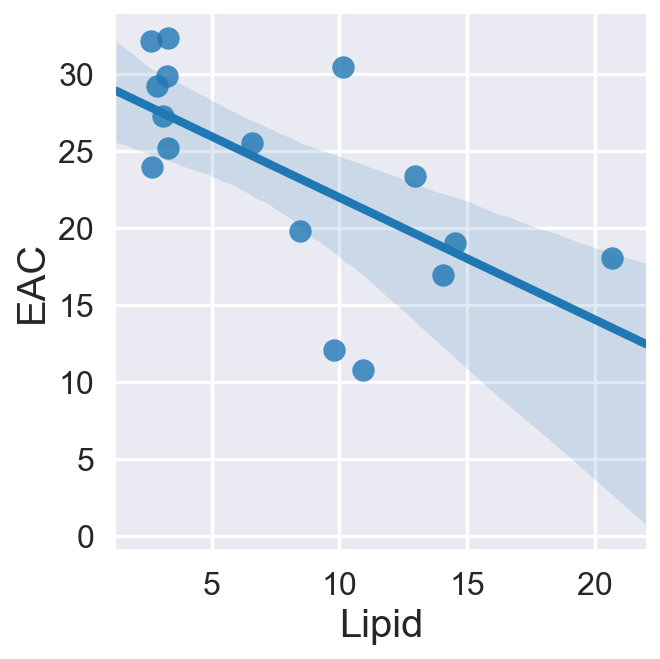

In [24]:
sns.lmplot(x = 'Lipid', y = 'EAC', data = df)

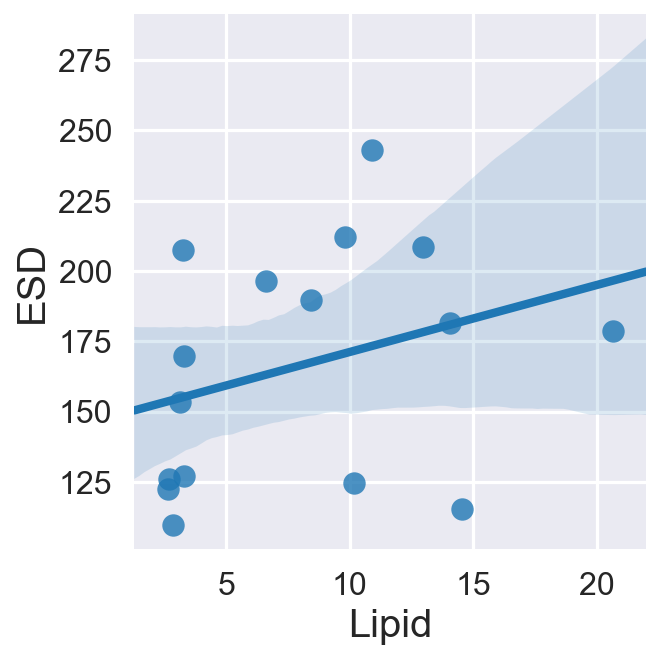

In [25]:
sns.lmplot(x = 'Lipid', y = 'ESD',data = df)

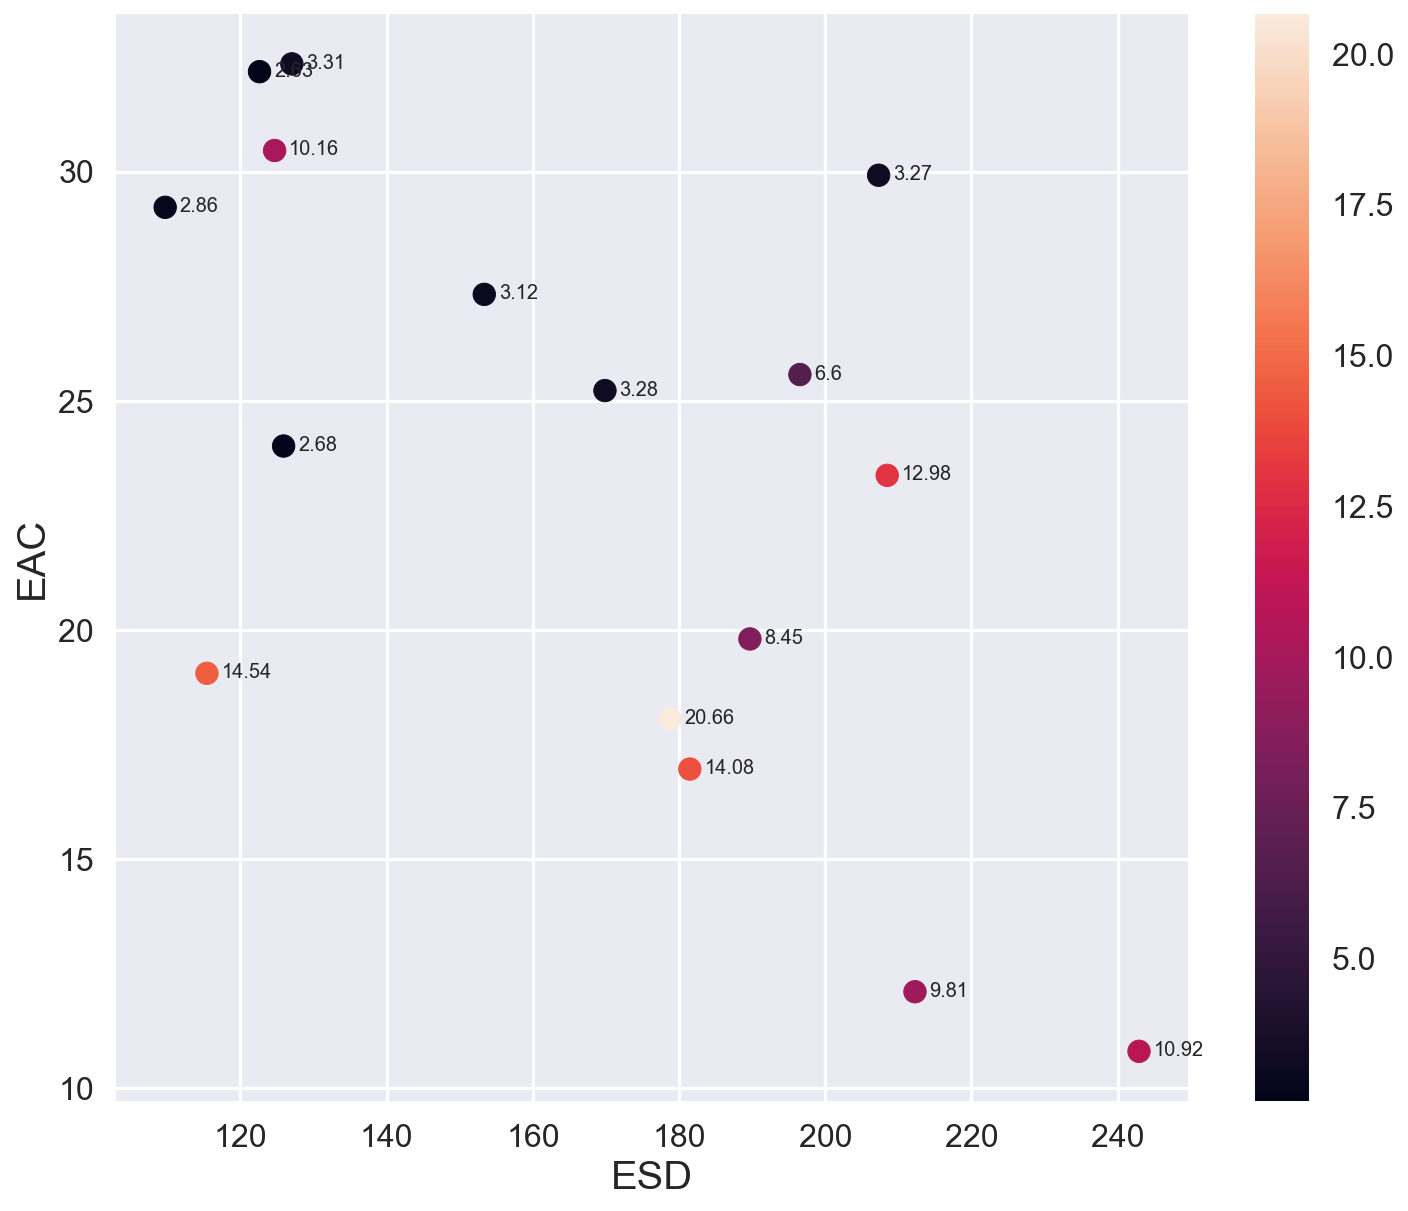

In [26]:
plt.figure(figsize = (12, 10))
plt.scatter(esd_eac_lipid[:,0], esd_eac_lipid[:,1], c = esd_eac_lipid[:,4])
for i, txt in enumerate(esd_eac_lipid[:,4]):
    plt.text(esd_eac_lipid[i,0]+ 2,esd_eac_lipid[i,1]-0.1, txt, fontsize = 10)
plt.xlabel('ESD')
plt.ylabel('EAC')
plt.colorbar()

In [25]:
X = np.vstack((esd_eac_lipid[:,0], esd_eac_lipid[:,1]))

In [26]:
y = (esd_eac_lipid[:,4] >=8).astype(float)

In [28]:
from mlxtend.plotting import plot_decision_regions

In [45]:
sns.set_style('white')

Text(0,0.5,'EAC (dB/$cm^3$)')

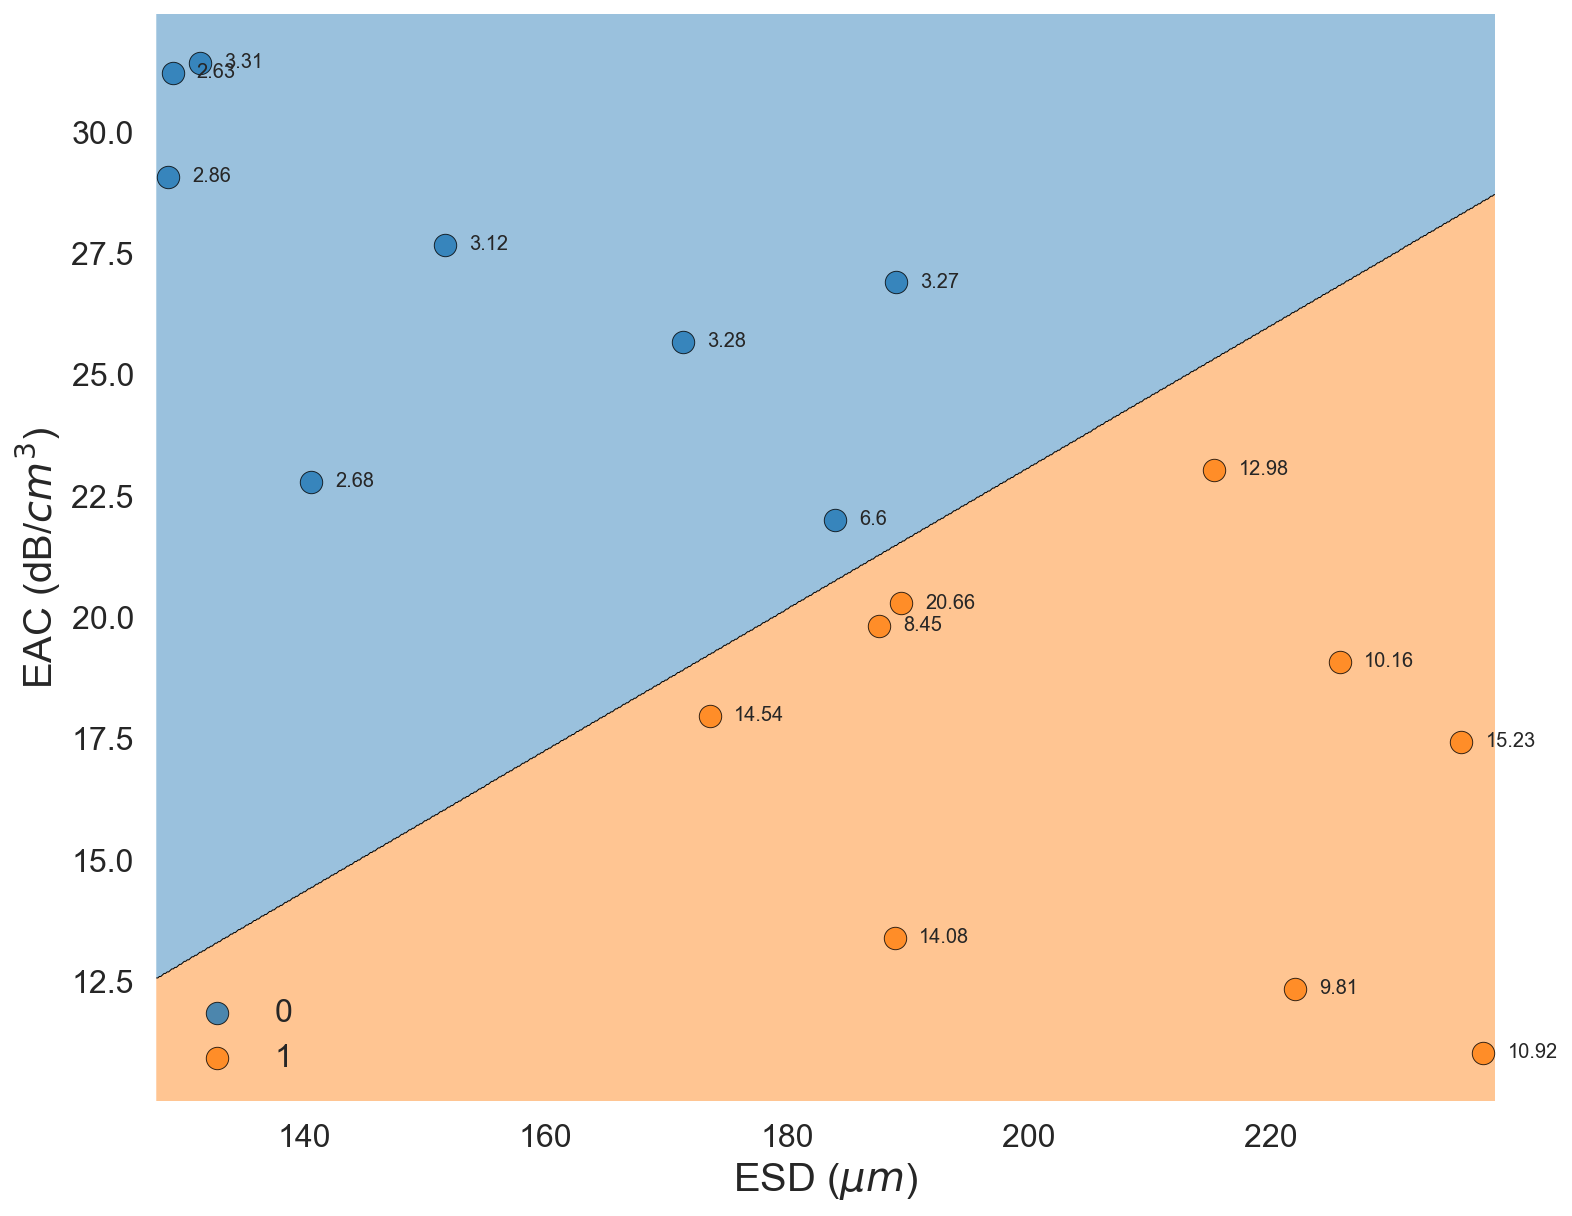

In [50]:
svc = svm.SVC(kernel='linear', C=10, gamma=0.001).fit(X.T, y)
# , colors = 'blue,red'
plt.figure(figsize = (12, 10))
plot_decision_regions(X.T, y.astype(np.integer), clf=svc, res=0.02, legend=3, markers = 'oo')
for i, txt in enumerate(esd_eac_lipid[:,4]):
    plt.text(esd_eac_lipid[i,0]+ 2,esd_eac_lipid[i,1]-0.1, txt, fontsize = 10)


plt.xlabel('ESD ($\mu m$)')
plt.ylabel('EAC (dB/$cm^3$)')

In [57]:
df

,ESD,EAC,Slope,Intercept,Lipid,High
0,122.61,32.18,0.59,-8.20,2.63,False
1,125.90,24.01,0.56,-10.07,2.68,False
2,109.70,29.22,0.66,-9.74,2.86,False
3,153.35,27.32,0.36,-7.52,3.12,False
4,207.30,29.92,-0.19,-4.39,3.27,False
5,169.86,25.22,0.21,-7.11,3.28,False
6,127.03,32.35,0.56,-8.02,3.31,False
7,196.53,25.57,-0.12,-5.68,6.60,False
8,189.69,19.80,0.01,-7.54,8.45,True
9,212.27,12.10,-0.24,-8.22,9.81,True


In [51]:
df[df.High ==False].ESD.mean()

153.21750000000003

In [52]:
df[df.High ==True].ESD.mean()

208.44555555555556

In [53]:
df[df.High ==False].EAC.mean()

27.09375

In [54]:
df[df.High == True].EAC.mean()

17.15

In [33]:
df[df.High ==False].Slope.mean()

0.34375

In [34]:
df[df.High == True].Slope.mean()

-0.21111111111111114

In [35]:
df[df.High ==False].Intercept.mean()

-7.723750000000001

In [36]:
df[df.High == True].Intercept.mean()

-7.033333333333333

In [37]:
np.corrcoef(esd_eac_lipid[:,2], esd_eac_lipid[:,0])

array([[ 1.        , -0.99524079],
       [-0.99524079,  1.        ]])

In [38]:
np.corrcoef(esd_eac_lipid[:,2], esd_eac_lipid[:,1])

array([[ 1.        ,  0.77668862],
       [ 0.77668862,  1.        ]])

In [39]:
get_ESD_EAC(freq.squeeze(), X2)

(140.08320584820123, 21.076787914875336)

In [ ]:
for idx in np.arange(0, X_train.shape[1], 4000):
    X1 = X_train[:, idx]
    print(y_train[idx])
    plt.semilogy(freq.squeeze(), X1)
    
    ESD, EAC = get_ESD_EAC(freq.squeeze(), X1)
    title = "ESD: "+ str(ESD) + " EAC: " + str(EAC)
    plt.title(title)
    plt.show()

In [53]:
get_ESD_EAC(freq.squeeze(), X1)

(183.1273143723204, 26.574334734034895)

In [74]:
linear_train = features_gaussian_ff(X_train,freq.squeeze())

In [134]:
np.polyfit(freq.squeeze(), np.log(X2), 1)

array([ 0.21223546, -8.25130119])

In [130]:
def linearFit(BSCs, f):
    lineFit = np.zeros((BSCs.shape[0], 2)) #allocate the matrix
    for i in range(0, BSCs.shape[0]):
        coeff = np.polyfit(np.ravel(f), BSCs[i,:], 1) # since BSCs is already in LOG form 
        lineFit[i,:] = coeff # fit a line into the BSCs
    return lineFit 

[735, 738, 746, 757]
734,732,Skip,Skip,737,736,741,752,739,Skip,747,754,745,743,740,731,755,Skip,758,Skip, Skip, 735,738,Skip, Skip, Skip, Skip, Skip, 746,Skip, Skip, Skip, Skip, Skip, Skip, Skip, 757,Skip, Training accuracy: 0.760082362965
Testing accuracy: 0.649347778023


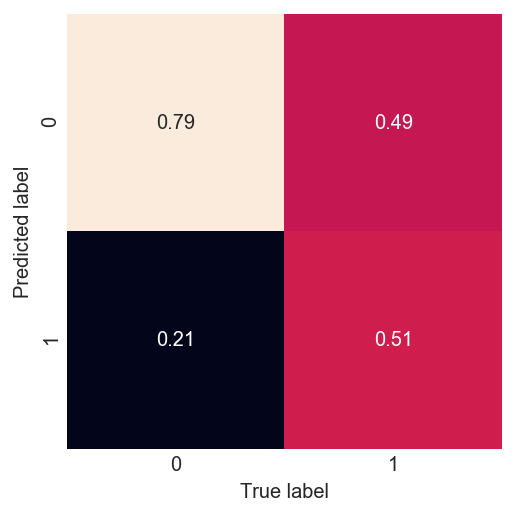

[741, 736, 740, 754]
734,732,735,738,737,Skip,Skip,752,739,746,747,Skip,745,743,Skip,731,755,757,758,Skip, Skip, Skip, Skip, Skip, 736,741,Skip, Skip, Skip, Skip, 754,Skip, Skip, 740,Skip, Skip, Skip, Skip, Training accuracy: 0.7576443209
Testing accuracy: 0.644040790312


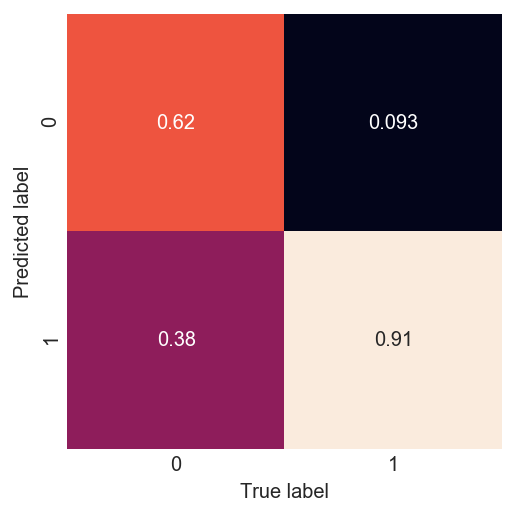

[737, 732, 755, 745]
734,Skip,735,738,Skip,736,741,752,739,746,747,754,Skip,743,740,731,Skip,757,758,Skip, 732,Skip, Skip, 737,Skip, Skip, Skip, Skip, Skip, Skip, Skip, 745,Skip, Skip, Skip, 755,Skip, Skip, Training accuracy: 0.759926739927
Testing accuracy: 0.682872705265


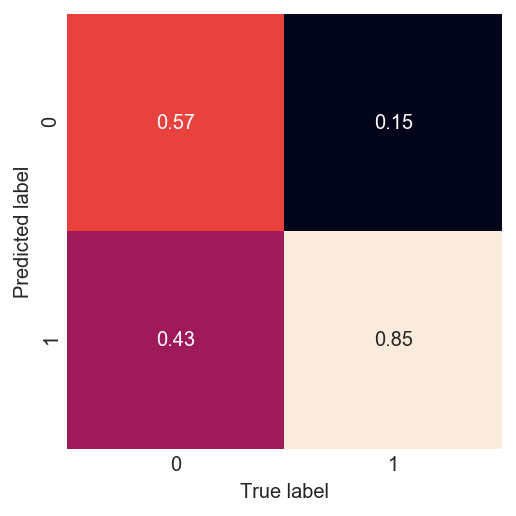

In [27]:
for i in range(3):
    testing_idx = all_idx[i*4:i*4+4]
    print(testing_idx)
    X_train, y_train = fattyLiver.get_training_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict)
    X_test, y_test = fattyLiver.get_testing_data(dataBase, testing_idx, BSCs_dict, freq_bsc_dict, depth_dict)

    # Randomize the training data. The testing data was not randomized to get the frame by frame accuracy. 
    #(possible to randomize, but need to keep track of the randomization, seems unneccessary). 
    X_train = X_train.T
    X_test = X_test.T
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    X_log_train = np.log10(X_train+0.001)
    X_log_test = np.log10(X_test+0.001)
    linear_train = linearFit(X_log_train,freq)
    linear_test = linearFit(X_log_test,freq)
    
    #esd_eac_train = features_gaussian_ff(X_train, freq.squeeze())
    #esd_eac_test = features_gaussian_ff(X_test, freq.squeeze())
    
    linear_svm = svm.SVC()
    #clf = RandomForestClassifier(n_estimators=2000)
    clf = svm.SVC(C=1.0, kernel='linear', gamma=0.1)
    clf.fit(linear_train, y_train)
    
    linear_predict  = clf.predict(linear_test)
    linear_train_predict = clf.predict(linear_train)
    
    print("Training accuracy:", accuracy_score(y_train, linear_train_predict))
    print("Testing accuracy:", accuracy_score(y_test, linear_predict))
    
    linear_cm = confusion_matrix(y_test, linear_predict)
    n_cm_ln = linear_cm.astype('float') / linear_cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(n_cm_ln.T, square=True, annot=True, cbar=False)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()

In [40]:
(75. + 48.14 + 71.52 + 89.54 + 60.35 + 65.41) /6

68.32666666666667

In [35]:
freq

array([[ 3.        ],
       [ 3.00195503],
       [ 3.00391007],
       ..., 
       [ 4.99608993],
       [ 4.99804497],
       [ 5.        ]])

In [57]:
linear_train = linearFit(X_train,freq)
linear_test = linearFit(X_test,freq)

In [59]:
linear_svm = svm.SVC()
linear_svm.fit(linear_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
linear_predict  = linear_svm.predict(linear_test)

In [61]:
linear_cm = confusion_matrix(y_test, linear_predict)
n_cm_ln = linear_cm.astype('float') / linear_cm.sum(axis=1)[:, np.newaxis]

In [187]:
newdataBase = pd.read_excel('/Users/trongnguyen/Dropbox/FattyLiver/Rabbit_Liver_40.xlsx', sheet_name=0)
aliveOnly = newdataBase[newdataBase['Timely death'] == 1][['Rabbit', 'Weeks on diet', 'Lipid', 'Injection level']]
dataBase1 = aliveOnly.dropna()
dataBase1  = dataBase[(dataBase['Rabbit']<759)] # first 27 rabbits


In [188]:
dataBase1

,Rabbit,Weeks on diet,Lipid,Injection level,High
0,734,1,2.63,2,False
1,732,1,2.68,1,False
2,735,3,2.86,2,False
3,738,6,3.12,3,False
4,729,0,3.27,0,False
5,737,3,3.28,3,False
7,736,0,3.31,3,False
10,752,1,6.60,0,True
13,751,1,8.20,0,True
14,746,6,8.45,2,True
